# Understanding electron track parents cut

## Imports

In [1]:
import sys
sys.path.append("/home/sgrant/pyutils-dev/EventNtuple/utils/pyutils")
import uproot
import awkward as ak
import matplotlib.pyplot as plt
from pyimport import Importer
from pyplot import Plot
from pyprint import Print
from pyselect import Select
from pyvector import Vector

# Import data

In [136]:
importer = Importer( 
    use_remote = True,
    location = "disk",
    verbosity = 1
)

branches = { 
    "evt" : [
        "run",
        "subrun",
        "event",
    ],
    "trk" : [
        "trk.nactive", 
        "trk.pdg", 
        "trkqual.valid",
        "trkqual.result"
    ],
    "trkfit" : [
        "trksegs",
        "trksegpars_lh"
    ],
    "trkmc" : [
        "trkmcsim"
    ]
}

# Single file
data = importer.import_file(
    file_name = "nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00050440.root",
    # branches = "*"
    branches = branches
)

[pyimport] Initialised Importer with path 'EventNtuple/ntuple' and verbosity=1
[pyimport] ✅ Imported branches


In [61]:
data.type.show()

6932 * {
    evt: {
        event: int32,
        run: int32,
        subrun: int32
    },
    trk: {
        "trk.pdg": var * int32,
        "trk.nactive": var * int32,
        "trkqual.valid": var * bool,
        "trkqual.result": var * float32
    },
    trkfit: {
        trksegs: var * var * struct[{
            mom: struct[{
                fCoordinates: struct[{
                    fX: float32,
                    fY: float32,
                    fZ: float32
                }, parameters={"__record__": "ROOT::Math::Cartesian3D<float>"}]
            }, parameters={"__record__": "ROOT::Math::DisplacementVector3D<ROOT::Math::Cartesian3D<float>,ROOT::Math::DefaultCoordinateSystemTag>"}],
            pos: struct[{
                fCoordinates: struct[{
                    fX: float32,
                    fY: float32,
                    fZ: float32
                }, parameters={"__record__": "ROOT::Math::Cartesian3D<float>"}]
            }, parameters={"__record__": "ROOT::Math::Disp

## Electrons in-tracker according to track pdg  
### Construct track parent electron mask based on truth

In [138]:
is_electron = data["trkmc"]["trkmcsim"]["pdg"] == 11
is_trk_parent = data["trkmc"]["trkmcsim"]["nhits"] == ak.max(data["trkmc"]["trkmcsim"]["nhits"], axis=-1)
is_trk_parent_electron = is_electron & is_trk_parent 
has_trk_parent_electron = ak.any(is_trk_parent_electron, axis=-1) # Are any of these track parent electrons

data["is_electron"] = is_electron
data["is_trk_parent"] = is_trk_parent
data["is_trk_parent_electron"] = is_trk_parent_electron
data["has_trk_parent_electron"] = has_trk_parent_electron

printer = Print()
printer.print_n_events(data, n_events=1)

[pyprint] Initialised Print with verbose = False and precision = 1

[pyprint] ---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
evt.event: 15289
evt.run: 1202
evt.subrun: 50440
trk.trk.pdg: [-11, 11, 13]
trk.trk.nactive: [62, 76, 63]
trk.trkqual.valid: [True, True, True]
trk.trkqual.result: [0.0451, 0.337, 0.0252]
trkfit.trksegs.mom.fCoordinates.fX: [[-5.16, -15.9, 20.1, -8.59, -19], [20.1, ...], [8.93, 14.6, -10, -25.8]]
trkfit.trksegs.mom.fCoordinates.fY: [[-43.7, 34.3, 26, -30.7, 22.9], [-24.2, ...], [29.3, -21.7, -29.3, -24.5]]
trkfit.trksegs.mom.fCoordinates.fZ: [[14.5, 26.7, 32.6, 32.8, 33.8], [-33.8, ...], [-32.3, -28, -22.6, -14.3]]
trkfit.trksegs.pos.fCoordinates.fX: [[385, 274, 329, 518, 342], [335, 516, ..., 364], [517, 355, 297, 273]]
trkfit.trksegs.pos.fCoordinates.fY: [[174, 177, 310, 217, 188], [182, 216, ..., 134], [216, 214, 253, 240]]
trkfit.trksegs.pos.fCoordinates.fZ: [[-5.97e+03, -3.9e+03, -1.63e+03, 

### Apply event level cut

In [139]:
data_cut = ak.copy(data)

data_cut["trk"] = data["trk"][has_trk_parent_electron] 
data_cut["trkfit"] = data["trkfit"][has_trk_parent_electron] 
data_cut["trkmc"] = data["trkmc"][has_trk_parent_electron]

combined = ak.any(has_trk_parent_electron, axis=-1) # clean events with no tracks left

data_cut = data_cut[combined]

printer.print_n_events(data_cut, n_events=1)

# Inspect
print(f"{len(data_cut)}/{len(data)} events remaining") 


[pyprint] ---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
evt.event: 15289
evt.run: 1202
evt.subrun: 50440
is_electron: [[True, False, False], [True, False, False], [True, False, False]]
is_trk_parent: [[True, False, False], [True, False, False], [True, False, False]]
is_trk_parent_electron: [[True, False, False], [True, False, False], [True, False, False]]
has_trk_parent_electron: [True, True, True]
trk.trk.pdg: [-11, 11, 13]
trk.trk.nactive: [62, 76, 63]
trk.trkqual.valid: [True, True, True]
trk.trkqual.result: [0.0451, 0.337, 0.0252]
trkfit.trksegs.mom.fCoordinates.fX: [[-5.16, -15.9, 20.1, -8.59, -19], [20.1, ...], [8.93, 14.6, -10, -25.8]]
trkfit.trksegs.mom.fCoordinates.fY: [[-43.7, 34.3, 26, -30.7, 22.9], [-24.2, ...], [29.3, -21.7, -29.3, -24.5]]
trkfit.trksegs.mom.fCoordinates.fZ: [[14.5, 26.7, 32.6, 32.8, 33.8], [-33.8, ...], [-32.3, -28, -22.6, -14.3]]
trkfit.trksegs.pos.fCoordinates.fX: [[385, 274, 329, 518

### Plot particles in tracker

[pyplot] Initialised Plot with mu2e.mplstyle and verbosity = 1
Help on method plot_1D_overlay in module pyplot:

plot_1D_overlay(hists_dict, weights=None, nbins=100, xmin=-1.0, xmax=1.0, title=None, xlabel=None, ylabel=None, out_path=None, dpi=300, leg_pos='best', log_x=False, log_y=False, norm_by_area=False, ax=None, show=True) method of pyplot.Plot instance
    Overlay multiple 1D histograms from a dictionary of arrays.

    Args:
        hists_dict (Dict[str, np.ndarray]): Dictionary mapping labels to arrays
        weights (List[np.ndarray], optional): List of weight arrays for each histogram
        nbins (int, optional): Number of bins. Defaults to 100
        xmin (float, optional): Minimum x-axis value. Defaults to -1.0
        xmax (float, optional): Maximum x-axis value. Defaults to 1.0
        title (str, optional): Plot title
        xlabel (str, optional): X-axis label
        ylabel (str, optional): Y-axis label
        out_path (str, optional): Path to save the plot
    

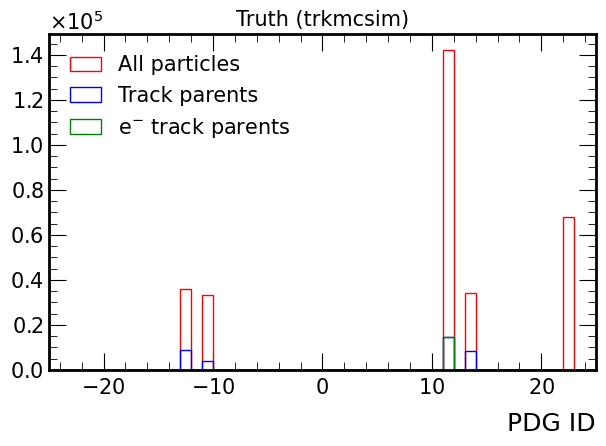

In [155]:
plotter = Plot()

trkmc = data["trkmc"]
trkmc_parents = data["trkmc"][data["is_trk_parent"]]
trkmc_parent_electrons = data["trkmc"][data["is_trk_parent_electron"]]

help(plotter.plot_1D_overlay)

plotter.plot_1D_overlay(
    {
        "All particles": ak.flatten(trkmc["trkmcsim"]["pdg"], axis=None),
        "Track parents": ak.flatten(trkmc_parents["trkmcsim"]["pdg"], axis=None),
        "$e^{-}$ track parents": ak.flatten(trkmc_parent_electrons["trkmcsim"]["pdg"], axis=None)
    },
    nbins=50, xmin=-25, xmax=25,
    xlabel="PDG ID", title="Truth (trkmcsim)",
    norm_by_area=False,
    show=True,
    out_path="../img/h1o_electron_cut.png"
)